# Short introduction to **polychrom** simulations of DNA 3D structure

This is a notebook version of the [polychrom simulations examples](https://github.com/open2c/polychrom/tree/master/examples) with a brief introduction of relevant concepts. 


### Installation of the libraries


Dependencies: 
- 3D simulations: [polychrom](https://github.com/open2c/polychrom)
- Visualization of 3D conformations: [nglview](https://github.com/nglviewer/nglview) and [nglutils](https://github.com/mirnylab/nglutils) (you can use other tools). 
nglview is relatively fast conformations viewer, simplifying a generation of nice graphics. However, it requres installation of widgets (which can be tricky for jupyter).

In [ ]:
! pip install simtk
! pip install nglview
! pip install git+https://github.com/mirnylab/nglutils.git
! pip install git+https://github.com/open2c/polychrom.git

In [ ]:
! conda install -c conda-forge openmm

### import libraries

In [1]:
import openmm

In [2]:
import polychrom
from polychrom import starting_conformations
from polychrom import polymerutils
from polychrom import forces
from polychrom import forcekits
from polychrom.simulation import Simulation
from polychrom import contactmaps

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


In [3]:
import nglutils.nglutils as ngu # from https://github.com/mirnylab/nglutils
import nglview as nv
import numpy as np
import matplotlib.pyplot as plt

## Chromatin structure simulations

### 1. Initial conformation

In [25]:
# Number of monomers in a single chain of polymer
N = 1000

In [26]:
# Random walk creates very large conformations with low density of points. 
xyz = starting_conformations.create_random_walk(1, N)

In [27]:
view_simple = ngu.xyz2nglview(xyz)
view_simple

NGLWidget()

In [29]:
view_simple.render_image(trim=True, factor=2, transparent=True);

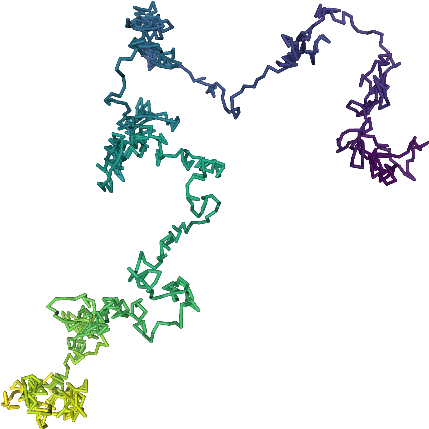

In [30]:
view_simple._display_image()

In [32]:
# To initialize a compact structure, use self-avoiding random walk on cubic grid
xyz = polychrom.starting_conformations.grow_cubic(N=N, boxSize=50, method='standard')

In [34]:
view_simple = ngu.xyz2nglview(xyz)
view_simple

NGLWidget()

In [35]:
view_simple.render_image(trim=True, factor=2, transparent=True);

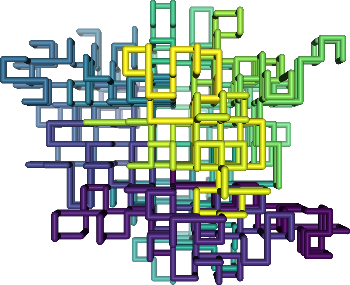

In [36]:
view_simple._display_image()

### 2. Forces

In [37]:
# Let's increase the number of monomers
N = 4000

#### Run the simulation

Example of simluations with monomers connected by harmonic bonds with repulsive force and angle force. 

Further reading: 
- Langevin integrator, more details on integrators: [OpenMM integrators page](http://docs.openmm.org/latest/userguide/theory/04_integrators.html)

- [Integrators implemented in polychrom](https://polychrom.readthedocs.io/en/latest/polychrom.simulation.html)

In [39]:
dens = 0.1
box = (N / dens) ** 0.33  # adjust for the polymer density
data = polychrom.starting_conformations.grow_cubic(N, int(box) - 2)  # create compact structure

a = Simulation(
        platform="cuda",
        integrator="variableLangevin",
        error_tol=0.01,
        GPU = "0",
        collision_rate=0.03,
        N = len(data),
        PBCbox=[box, box, box],
        precision="mixed")

a.set_data(data)  # load the data into the simulations object

a.add_force(
    forcekits.polymer_chains(
        a,
        chains=[(0, None, 0)],
        bond_force_func=forces.harmonic_bonds,
        bond_force_kwargs={
            'bondLength':1.0,
            'bondWiggleDistance':0.1,
          },

        angle_force_func=forces.angle_force,
        angle_force_kwargs={
            'k':1.5
        },

        nonbonded_force_func=forces.polynomial_repulsive,
        nonbonded_force_kwargs={
            'trunc':1.5,
            'radiusMult':1.05,
        },

        except_bonds=True,

    )
)
a.local_energy_minimization()

INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2
INFO:root:Particles loaded. Potential energy is 1.809169
INFO:root:before minimization eK=1.5170391402503887, eP=1.8091693672737459, time=0.0 ps


Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 3999


INFO:root:Particles loaded. Potential energy is 0.105485
INFO:root:after minimization eK=1.5170391402503887, eP=0.07629241495518416, time=0.0 ps


#### Structure before the simulations

In [40]:
view_simple = ngu.xyz2nglview(data)
view_simple

NGLWidget()

In [41]:
view_simple.render_image(trim=True, factor=2, transparent=True);

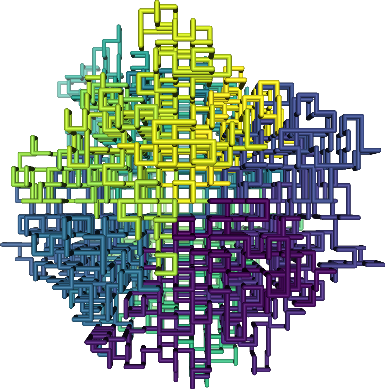

In [43]:
view_simple._display_image()

#### Structure after a single round of applying forces

In [44]:
data = a.get_data()
view_simple = ngu.xyz2nglview(data)
view_simple

NGLWidget()

In [45]:
view_simple.render_image(trim=True, factor=2, transparent=True);

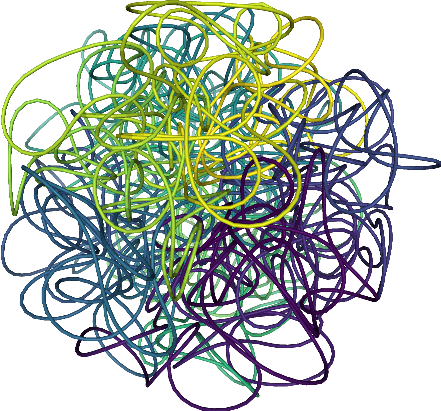

In [47]:
view_simple._display_image()

#### Structure after multiple steps of simulations

In [48]:
a.do_block(steps=1000)
data = a.get_data()
view_simple = ngu.xyz2nglview(data)
view_simple

INFO:root:block    0 pos[1]=[13.9 10.6 9.3] dr=5.94 t=172.1ps kin=1.52 pot=1.34 Rg=14.897 SPS=1708 dt=173.2fs dx=47.68pm 


NGLWidget()

In [49]:
view_simple.render_image(trim=True, factor=2, transparent=True);

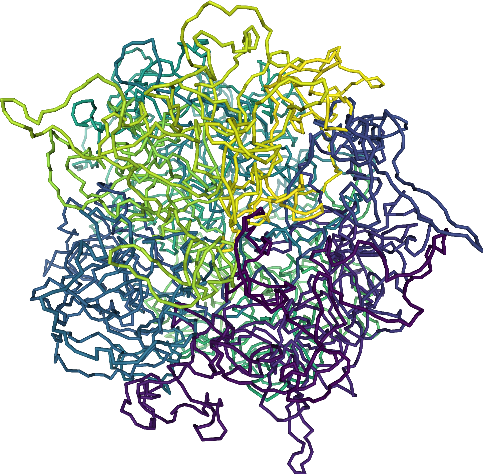

In [51]:
view_simple._display_image()

### 3. Visualizing typical modelling readouts

#### Contact map of single conformation

In [134]:
from polychrom import polymer_analyses

contacts = polymer_analyses.calculate_contacts(data, cutoff=5)

matrix = np.zeros([N, N])
for x, y in contacts:
    matrix[x, y] += 1
    matrix[y, x] += 1

In [135]:
import scipy
scipy.stats.describe(matrix.flatten())

DescribeResult(nobs=16000000, minmax=(0.0, 1.0), mean=0.065868125, variance=0.06152951895457931, skewness=3.500337520872906, kurtosis=10.252362760030667)

Text(0.5, 1.0, 'Contact map of a single conformation')

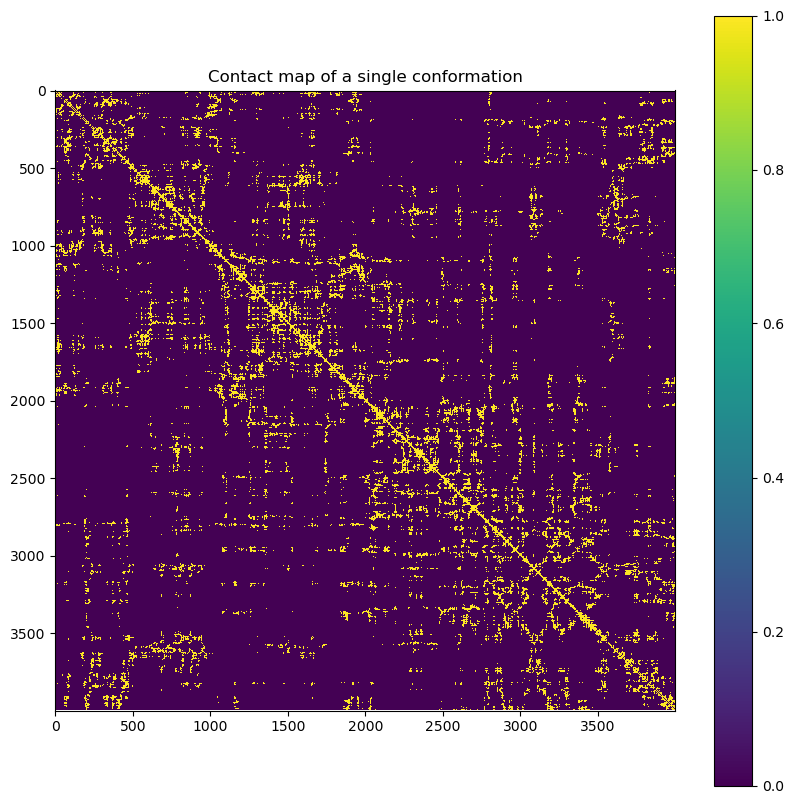

In [136]:
plt.figure(figsize=[10, 10])
plt.imshow(matrix, vmax=1, interpolation="none")
plt.colorbar()
plt.title('Contact map of a single conformation')

#### Scaling plot of a single conformation

In [137]:
dist, ps = polymer_analyses.contact_scaling(data, cutoff=5)

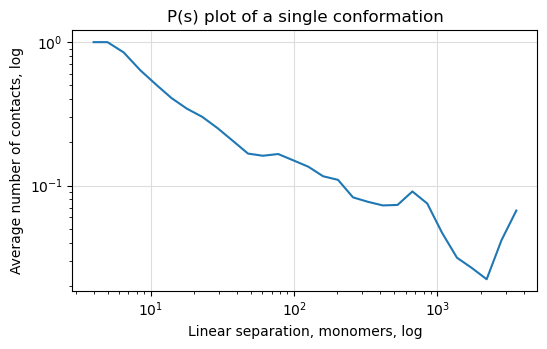

In [138]:
fig, ax = plt.subplots(1, 1, figsize=[6, 6])
ax.loglog(dist, ps)
ax.set_xlabel('Linear separation, monomers, log')
ax.set_ylabel('Average number of contacts, log')
ax.set_title('P(s) plot of a single conformation')
ax.set_aspect(1)
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)

### 4. Building ensemble of models

Building ensembe of models typically requires storing these models on the hard drive to save the RAM. 
polychrom implements hdf5-based reporter for storage and loading of the models. 

In [139]:
N = 4000 # polymer length
nblocks = 100 # number of iterations of simulations
steps = 1000 # number of steps in each simulation

In [140]:
from polychrom.hdf5_format import HDF5Reporter

# Initialize the reporter:
reporter = HDF5Reporter(folder="trajectory_simple_polymer", max_data_length=5, overwrite=True)
sim = Simulation(
    platform="CUDA",
    integrator="variableLangevin",
    error_tol=0.003,
    GPU="0",
    collision_rate=0.03,
    N=N,
    save_decimals=2,
    PBCbox=False,
    reporters=[reporter],
)

# Initialize the conformation and the forces:
polymer = starting_conformations.grow_cubic(N, 100)

sim.set_data(polymer, center=True)  # loads a polymer, puts a center of mass at zero

sim.add_force(forces.spherical_confinement(sim, density=0.85, k=1))

sim.add_force(
    forcekits.polymer_chains(
        sim,
        chains=[(0, None, False)],
        # By default the library assumes you have one polymer chain
        # If you want to make it a ring, or more than one chain, use self.setChains
        # self.setChains([(0,50,True),(50,None,False)]) will set a 50-monomer ring and a chain from monomer 50 to the end
        bond_force_func=forces.harmonic_bonds,
        bond_force_kwargs={
            "bondLength": 1.0,
            "bondWiggleDistance": 0.05,  # Bond distance will fluctuate +- 0.05 on average
        },
        angle_force_func=forces.angle_force,
        angle_force_kwargs={
            "k": 1.5,
            # K is more or less arbitrary, k=4 corresponds to presistence length of 4,
            # k=1.5 is recommended to make polymer realistically flexible; k=8 is very stiff
        },
        nonbonded_force_func=forces.polynomial_repulsive,
        nonbonded_force_kwargs={
            "trunc": 3.0,  # this will let chains cross sometimes
            #'trunc':10.0, # this will resolve chain crossings and will not let chain cross anymore
        },
        except_bonds=True,
    )
)

# Run simulations
for _ in range(nblocks):  # Do 10 blocks
    sim.do_block(steps)  # Of 100 timesteps each. Data is saved automatically.
sim.print_stats()  # In the end, print very simple statistics

# Store the output:
reporter.dump_data()  # always need to run in the end to dump the block cache to the disk

INFO:root:adding force spherical_confinement 0
INFO:root:adding force harmonic_bonds 1
INFO:root:adding force angle 2
INFO:root:adding force polynomial_repulsive 3
INFO:root:Particles loaded. Potential energy is 1.946601


Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 3999


INFO:root:block    0 pos[1]=[2.4 -4.0 -1.2] dr=2.96 t=64.8ps kin=1.57 pot=2.18 Rg=8.715 SPS=2838 dt=65.4fs dx=18.32pm 
INFO:root:block    1 pos[1]=[3.1 -2.5 -3.0] dr=2.34 t=130.2ps kin=1.51 pot=2.08 Rg=8.785 SPS=2809 dt=65.4fs dx=17.94pm 
INFO:root:block    2 pos[1]=[4.9 -1.9 -0.7] dr=2.36 t=195.6ps kin=1.52 pot=2.08 Rg=8.774 SPS=2890 dt=65.4fs dx=17.98pm 
INFO:root:block    3 pos[1]=[4.0 -2.6 -0.9] dr=2.23 t=261.0ps kin=1.50 pot=2.06 Rg=8.786 SPS=2771 dt=65.4fs dx=17.89pm 
INFO:root:block    4 pos[1]=[4.5 -3.5 -1.5] dr=2.26 t=326.4ps kin=1.50 pot=2.09 Rg=8.775 SPS=2733 dt=65.4fs dx=17.86pm 
INFO:root:block    5 pos[1]=[6.1 -1.6 -1.6] dr=2.25 t=391.8ps kin=1.52 pot=2.06 Rg=8.752 SPS=2794 dt=65.4fs dx=18.01pm 
INFO:root:block    6 pos[1]=[4.1 -0.0 -2.0] dr=2.22 t=457.2ps kin=1.51 pot=2.06 Rg=8.718 SPS=2830 dt=65.4fs dx=17.94pm 
INFO:root:block    7 pos[1]=[5.4 -0.8 -3.3] dr=2.23 t=522.6ps kin=1.48 pot=2.03 Rg=8.739 SPS=2995 dt=65.4fs dx=17.78pm 
INFO:root:block    8 pos[1]=[1.7 -2.5 -3.


 Statistics: number of particles: 4000

Statistics for particle position
     mean position is:  [ 0.05623649  0.0016481  -0.04082434]   Rg =  8.767713
     median bond size is  1.0007693418912065
     three shortest/longest (<10)/ bonds are  [0.88842812 0.89089792 0.89177558]    [1.11509363 1.12346112 1.12944106]
     95 percentile of distance to center is:    11.502723374469783
     density of closest 95% monomers is:    0.5960640924091389
     density of the 5% closest to CoM monomers is:    0.7023248009498632
     min/median/mean/max coordinates are: 
     x: -11.41, 0.02, 0.06, 12.36
     y: -12.31, 0.03, 0.00, 11.86
     z: -11.06, -0.01, -0.04, 11.36

Statistics for velocities:
     mean kinetic energy is:  1.5268117976238282 should be: 1.5
     fastest particles are (in kT):  [8.27997743 8.32025241 8.78884262 9.20605563 9.34770408]

Statistics for the system:
     Forces are:  ['spherical_confinement', 'harmonic_bonds', 'angle', 'polynomial_repulsive']

Potential Energy Ep =  

#### Contact map of ensemble of models

In [158]:
from polychrom.hdf5_format import list_URIs, load_URI
from polychrom.contactmaps import monomerResolutionContactMap, monomerResolutionContactMapSubchains, binnedContactMap

URIs = list_URIs("trajectory_simple_polymer")

matrix = monomerResolutionContactMapSubchains(
    filenames=URIs,
    mapStarts=[0],
    mapN=N,
    cutoff=5,
    n=8,
    loadFunction=lambda x:load_URI(x)["pos"])

In [159]:
scipy.stats.describe(matrix.flatten())

DescribeResult(nobs=16000000, minmax=(0, 100), mean=6.513341125, variance=169.17791308800312, skewness=3.0488992895612834, kurtosis=11.898631334547737)

Text(0.5, 1.0, 'Contact map of ensemble of conformations')

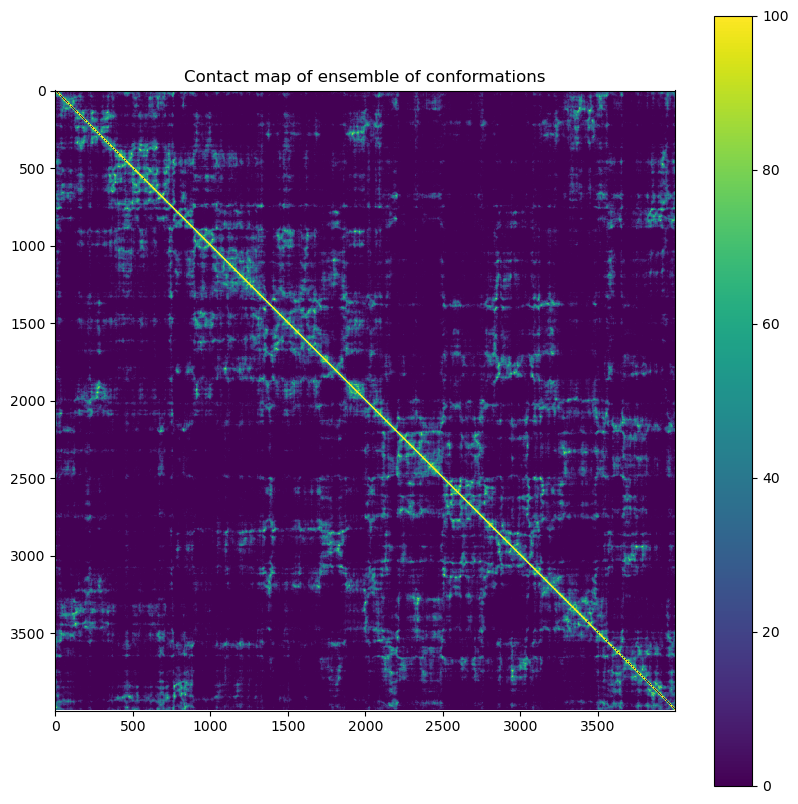

In [160]:
plt.figure(figsize=[10, 10])
plt.imshow(matrix, vmax=100, interpolation="none")
plt.colorbar()
plt.title('Contact map of ensemble of conformations')

#### Scaling plot of ensemble of conformations

In [161]:
pss = []

for uri in URIs:
    data = load_URI(uri)['pos']
    _, ps = polymer_analyses.contact_scaling(data, cutoff=5, bins0=dist)
    pss.append(ps)

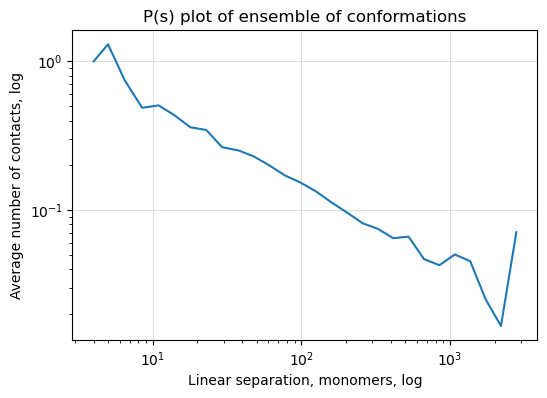

In [162]:
fig, ax = plt.subplots(1, 1, figsize=[6, 6])
ax.loglog(dist[:-1], np.mean(pss, axis=0))
ax.set_xlabel('Linear separation, monomers, log')
ax.set_ylabel('Average number of contacts, log')
ax.set_title('P(s) plot of ensemble of conformations')
ax.set_aspect(1)
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)

### 5. Simulating compartments

by adding attraction between beads

In [163]:
N = 4000
nblocks = 100
steps = 1000

# Let's simulate two types of beads: 
# A = 1; B = 2
# The list of compartment assignment for each monomer shall look like this:
# monomer_types_data = [1]*800 + [2]*1000 + ...  # should sum up to our N (4000)
# This is an example of monomer type assignment:
monomer_types_data = np.array( ( [2]*500 + [1]*500 ) * 4 ) # monomer types
monomer_types_data[100:200] = 1

# Beads of different types will be attracted by forces with different strengths,
# defined by 3x3 attraction matrix:
# [[0, 0, 0],[0, strength_AA, strength_AB], [0, stregth_BA, strength_BB]]
# where each strength is recommended to be around 0.05-0.2
interaction_matrix_data = np.array([[0, 0, 0], [0, 0.15, 0.0], [0, 0.0, 0.05]])

In [164]:
# For compartmental simulations we will use new type of force, forces.heteropolymer_SSW

dens = 0.2
box = (N / dens) ** 0.33  # density = 0.1.

reporter = HDF5Reporter(folder="trajectory_compartments", max_data_length=1000, overwrite=True)
sim = Simulation(
    platform="CUDA",
    integrator="variableLangevin",
    error_tol=0.01,
    GPU="0",
    collision_rate=0.01,
    N=N,
    save_decimals=2,
    PBCbox=False,
    reporters=[reporter]
)

polymer = polychrom.starting_conformations.grow_cubic(N, int(box) - 2)  # creates a compact conformation

sim.set_data(polymer, center=True)  # loads a polymer, puts a center of mass at zero

sim.add_force(forces.spherical_confinement(sim, density=1.0, k=1))

interaction_matrix = interaction_matrix_data
monomer_types = monomer_types_data

sim.add_force(
    forcekits.polymer_chains(
        sim,
        chains=[(0, None, 0)],

        nonbonded_force_func=forces.heteropolymer_SSW,
        nonbonded_force_kwargs={
            "interactionMatrix": interaction_matrix,
            "monomerTypes": monomer_types,
            "extraHardParticlesIdxs": [],
            "attractionEnergy": 0.5, "attractionRadius": 1.5,
        },

        bond_force_func=forces.harmonic_bonds,
        bond_force_kwargs={
            "bondLength": 1,
            "bondWiggleDistance": 0.05,
        },

        angle_force_func=forces.angle_force,
        angle_force_kwargs={
            "k": 1.5,
        },

    )
)

for _ in range(nblocks):
    sim.do_block(steps)
sim.print_stats()

reporter.dump_data()

INFO:root:adding force spherical_confinement 0
INFO:root:adding force harmonic_bonds 1
INFO:root:adding force angle 2
INFO:root:adding force heteropolymer_SSW 3
INFO:root:Particles loaded. Potential energy is -0.480998


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 3999


INFO:root:block    0 pos[1]=[-0.6 -0.9 1.2] dr=3.15 t=100.4ps kin=3.05 pot=1.55 Rg=7.371 SPS=2466 dt=102.1fs dx=39.85pm 
INFO:root:block    1 pos[1]=[-0.5 -0.4 2.5] dr=2.79 t=202.4ps kin=2.91 pot=1.47 Rg=7.388 SPS=2446 dt=102.1fs dx=38.91pm 
INFO:root:block    2 pos[1]=[-0.7 3.2 1.8] dr=2.72 t=304.5ps kin=2.79 pot=1.34 Rg=7.299 SPS=2441 dt=102.1fs dx=38.12pm 
INFO:root:block    3 pos[1]=[1.0 1.5 1.8] dr=2.61 t=406.6ps kin=2.87 pot=1.29 Rg=7.337 SPS=2443 dt=102.1fs dx=38.64pm 
INFO:root:block    4 pos[1]=[-0.2 -1.0 -1.0] dr=2.57 t=508.7ps kin=2.75 pot=1.23 Rg=7.346 SPS=2451 dt=102.1fs dx=37.78pm 
INFO:root:block    5 pos[1]=[0.8 0.4 -1.5] dr=2.59 t=610.8ps kin=2.75 pot=1.21 Rg=7.299 SPS=2456 dt=102.1fs dx=37.83pm 
INFO:root:block    6 pos[1]=[-0.1 -0.2 1.9] dr=2.60 t=712.9ps kin=2.81 pot=1.30 Rg=7.267 SPS=2438 dt=102.1fs dx=38.23pm 
INFO:root:block    7 pos[1]=[0.2 -0.9 3.8] dr=2.58 t=815.0ps kin=2.92 pot=1.34 Rg=7.269 SPS=2444 dt=102.1fs dx=38.95pm 
INFO:root:block    8 pos[1]=[-0.7 0.


 Statistics: number of particles: 4000

Statistics for particle position
     mean position is:  [ 9.15497118e-05  2.01835395e-01 -4.55707688e-01]   Rg =  7.2285237
     median bond size is  1.0033716384076088
     three shortest/longest (<10)/ bonds are  [0.82962234 0.8369185  0.84296798]    [1.17310032 1.17667992 1.18439994]
     95 percentile of distance to center is:    9.755446453916814
     density of closest 95% monomers is:    0.9771326809614568
     density of the 5% closest to CoM monomers is:    1.3981099985199752
     min/median/mean/max coordinates are: 
     x: -10.33, 0.07, 0.00, 9.59
     y: -11.01, 0.28, 0.20, 9.84
     z: -9.64, -0.67, -0.46, 9.67

Statistics for velocities:
     mean kinetic energy is:  3.2680428404904505 should be: 1.5
     fastest particles are (in kT):  [19.2761287  19.37702004 19.52841817 20.63188687 23.30486901]

Statistics for the system:
     Forces are:  ['spherical_confinement', 'harmonic_bonds', 'angle', 'heteropolymer_SSW']

Potential Ene

#### Structure before simulations

In [166]:
comps = ['A' if i==1 else "B" for i in monomer_types]
top = ngu.mdtop_for_polymer(len(data), atom_names=comps)

In [167]:
view = ngu.xyz2nglview(polymer, top=top)

In [168]:
view.center()
view.clear_representations()
view.add_representation('licorice', colorScheme='uniform',
                                     colorValue=0xcccccc,
                                     radius=0.1)
view.add_representation('ball+stick', selection='.A',
                                     colorScheme='uniform',
                                     colorValue=0x0000ff,
                                     radius=0.2)
view.add_representation('ball+stick', selection='.B',
                                     colorScheme='uniform',
                                     colorValue=0xff0000,
                                     radius=0.2)

In [169]:
view

NGLWidget()

In [170]:
view.render_image(trim=True, factor=2, transparent=True);

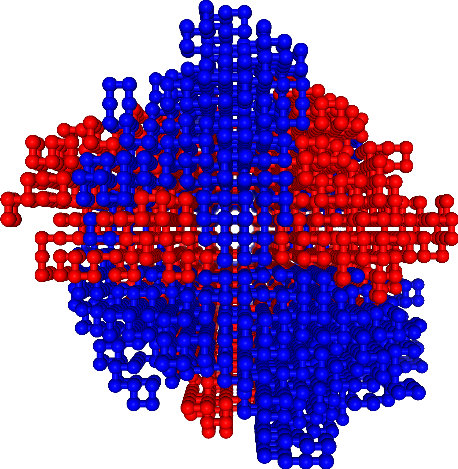

In [171]:
view._display_image()

#### Structure after simulations

In [174]:
view = ngu.xyz2nglview(data, top=top)

In [175]:
view.center()
view.clear_representations()
view.add_representation('licorice', colorScheme='uniform',
                                     colorValue=0xcccccc,
                                     radius=0.1)
view.add_representation('ball+stick', selection='.A',
                                     colorScheme='uniform',
                                     colorValue=0x0000ff,
                                     radius=0.3)
view.add_representation('ball+stick', selection='.B',
                                     colorScheme='uniform',
                                     colorValue=0xff0000,                                     radius=0.3)

In [176]:
view

NGLWidget()

In [177]:
view.render_image(trim=True, factor=2, transparent=True);

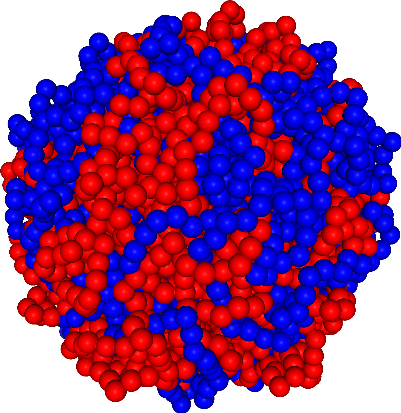

In [178]:
view._display_image()

#### Contact map for simulations with compartments

In [179]:
URIs = list_URIs("trajectory_compartments")
print(len(URIs))

matrix = monomerResolutionContactMapSubchains(
    filenames=URIs,
    mapStarts=[0],
    mapN=N,
    cutoff=5,
    n=8,
    loadFunction=lambda x:load_URI(x)["pos"])

100


Text(0.5, 1.0, 'Contact map with compartments')

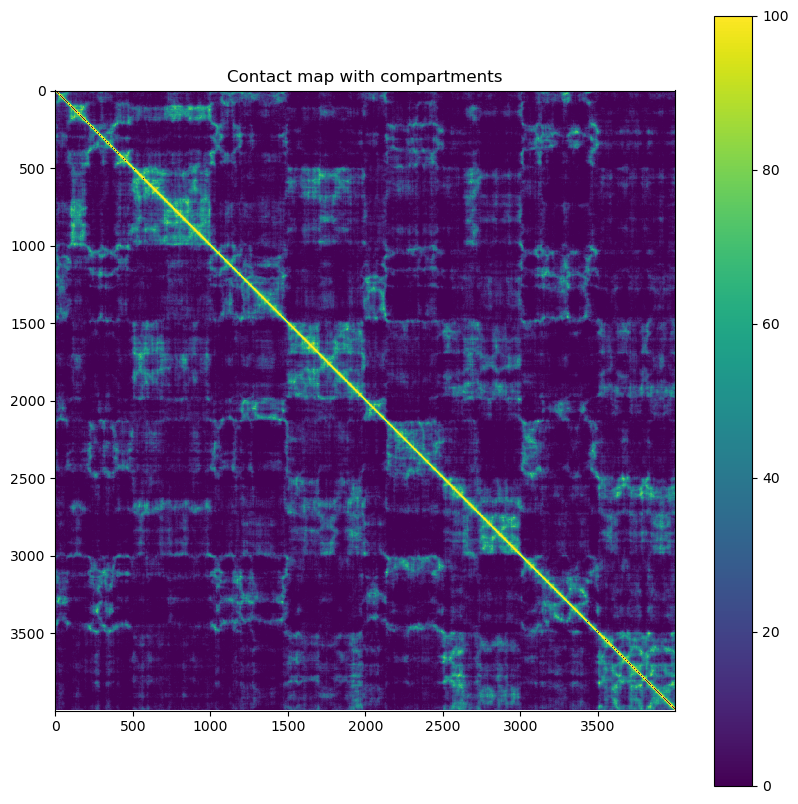

In [180]:
plt.figure(figsize=[10, 10])
plt.imshow(matrix, vmax=100, interpolation="none")
plt.colorbar()
plt.title('Contact map with compartments')

### 6. Simulating loop extrusion

Loop extrusion is usually simulated in two steps: 1D walk of extruders on DNA and 3D polymer simulations with extruders introduced as additional bonds.

#### 1D loop extrusion: code

Multiple solutions for 1D loop extrusion exist, we provide one of the basic examples provided in polychrom's examples.

In [181]:
import numpy as np
import pandas as pd
import h5py

class leg(object):
    def __init__(self, pos, attrs={"stalled":False, "CTCF":False}):
        """
        A leg has two important attribues: pos (positions) and attrs (a custom list of attributes)
        """
        self.pos = pos
        self.attrs = dict(attrs)

class cohesin(object):
    """
    A cohesin class provides fast access to attributes and positions


    cohesin.left is a left leg of cohesin, cohesin.right is a right leg
    cohesin[-1] is also a left leg and cohesin[1] is a right leg

    Also, cohesin.any("myattr") is True if myattr==True in at least one leg
    cohesin.all("myattr") is if myattr=True in both legs
    """
    def __init__(self, leg1, leg2):
        self.left = leg1
        self.right = leg2

    def any(self, attr):
        return self.left.attrs[attr] or self.right.attrs[attr]

    def all(self, attr):
        return self.left.attrs[attr] and self.right.attrs[attr]

    def __getitem__(self, item):
        if item == -1:
            return self.left
        elif item == 1:
            return self.right
        else:
            raise ValueError()


def unloadProb(cohesin, args):
    """
    Defines unload probability based on a state of cohesin
    """
    if cohesin.any("stalled"):
        # if one side is stalled, we have different unloading probability
        # Note that here we define stalled cohesins as those stalled not at CTCFs
        return 1 / args["LIFETIME_STALLED"]
    # otherwise we are just simply unloading
    return 1 / args["LIFETIME"]



def loadOne(cohesins, occupied, args):
    """
    A function to load one cohesin
    """
    while True:
        a = np.random.randint(args["N"])
        if (occupied[a] == 0) and (occupied[a+1] == 0):
            occupied[a] = 1
            occupied[a+1] = 1
            cohesins.append(cohesin(leg(a), leg(a+1)))
            break


def capture(cohesin, occupied, args):
    """
    We are describing CTCF capture here.
    This function is specific to this particular project, and
    users are encouraged to write functions like this

    Note the for-loop over left/right sites below, and using cohesin[side]
    to get left/right leg.

    Also note how I made ctcfCapture a dict with -1 coding for left side, and 1 for right side
    and ctcfCapture are dicts as well: keys are locations, and values are probabilities of capture
    """
    for side in [1, -1]:
        # get probability of capture or otherwise it is 0
        if np.random.random() < args["ctcfCapture"][side].get(cohesin[side].pos, 0):
            cohesin[side].attrs["CTCF"] = True  # captured a cohesin at CTCF
    return cohesin


def release(cohesin, occupied, args):

    """
    AN opposite to capture - releasing cohesins from CTCF
    """

    if not cohesin.any("CTCF"):
        return cohesin  # no CTCF: no release necessary

    # attempting to release either side
    for side in [-1, 1]:
        if (np.random.random() < args["ctcfRelease"][side].get(cohesin[side].pos, 0)) and (cohesin[side].attrs["CTCF"]):
            cohesin[side].attrs["CTCF"] = False
    return cohesin


def translocate(cohesins, occupied, args):
    """
    This function describes everything that happens with cohesins -
    loading/unloading them and stalling against each other

    It relies on the functions defined above: unload probability, capture/release.
    """
    # first we try to unload cohesins and free the matching occupied sites
    for i in range(len(cohesins)):
        prob = unloadProb(cohesins[i], args)
        if np.random.random() < prob:
            occupied[cohesins[i].left.pos] = 0
            occupied[cohesins[i].right.pos] = 0
            del cohesins[i]
            loadOne(cohesins, occupied, args)

    # then we try to capture and release them by CTCF sites
    for i in range(len(cohesins)):
        cohesins[i] = capture(cohesins[i], occupied, args)
        cohesins[i] = release(cohesins[i], occupied, args)

    # finally we translocate, and mark stalled cohesins because
    # the unloadProb needs this
    for i in range(len(cohesins)):
        cohesin = cohesins[i]
        for leg in [-1,1]:
            if not cohesin[leg].attrs["CTCF"]:
                # cohesins that are not at CTCFs and cannot move are labeled as stalled
                if occupied[cohesin[leg].pos  + leg] != 0:
                    cohesin[leg].attrs["stalled"] = True
                else:
                    cohesin[leg].attrs["stalled"] = False
                    occupied[cohesin[leg].pos] = 0
                    occupied[cohesin[leg].pos + leg] = 1
                    cohesin[leg].pos += leg
        cohesins[i] = cohesin

def color(cohesins, args):
    "A helper function that converts a list of cohesins to an array colored by cohesin state"
    def state(attrs):
        if attrs["stalled"]:
            return 2
        if attrs["CTCF"]:
            return 3
        return 1
    ar = np.zeros(args["N"])
    for i in cohesins:
        ar[i.left.pos] = state(i.left.attrs)
        ar[i.right.pos] = state(i.right.attrs)
    return ar

#### 1D loop extrusion: run

Here are the typical parameters for running loop extrusion with boudaries.

In [214]:
N1 = 4000 # size of one system
M = 10 # Number of times the system will be repeated
N = N1 * M

LIFETIME = 200
SEPARATION = 800
LEFNum = N // SEPARATION
trajectoryLength = 1000 # Number of simulation steps measured in number of cohesin steps; 
# this is a toy example; usually 100K steps is used to build Hi-C-like map

ctcf_capture = 0.9 # 80% capture probability
ctcf_release = 0.003

TADs = [300, 800, 1500, 2300, 2900, 3400]

In [215]:
ctcfLeftRelease = {}
ctcfRightRelease = {}
ctcfLeftCapture = {}
ctcfRightCapture = {}

for i in range(M):
    for tad in TADs:
        pos = i * N1 + tad
        ctcfLeftCapture[pos] = ctcf_capture  # 80% capture probability
        ctcfLeftRelease[pos] = ctcf_release  # hold it for ~300 blocks on average
        ctcfRightCapture[pos] = ctcf_capture
        ctcfRightRelease[pos] = ctcf_release

args = {}
args["ctcfRelease"] = {-1:ctcfLeftRelease, 1:ctcfRightRelease}
args["ctcfCapture"] = {-1:ctcfLeftCapture, 1:ctcfRightCapture}
args["N"] = N
args["LIFETIME"] = LIFETIME
args["LIFETIME_STALLED"] = LIFETIME  # no change in lifetime when stalled

##### Short example and visualization of 1D extrusion

On the X axis is the linear position in the polymer, on the Y axis is the time of simulations. Trajectory of each cohesin is highlighted in blue (running cohesin) and yellow (stalled cohesin).

In [223]:
occupied = np.zeros(N)
occupied[0] = 1
occupied[-1] = 1

cohesins = []
for i in range(LEFNum):
    loadOne(cohesins,occupied, args)

pos = []
for i in range(200):
    for _ in range(3):
        translocate(cohesins, occupied, args)
    pos.append(color(cohesins, args))

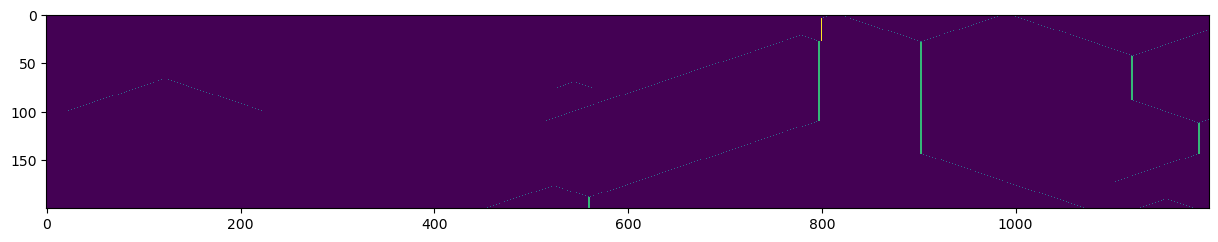

In [226]:
plt.figure(figsize=(15,10))
plt.imshow(np.array(pos)[:, 0:1200], interpolation="none")

##### Full example and storing 1D trajectories for further loading into 3D simulations

In [234]:
import time

In [247]:
import os
if not os.path.exists("trajectory_extrusion/"):
    os.mkdir("trajectory_extrusion")

In [248]:
occupied = np.zeros(N)
occupied[0] = 1
occupied[-1] = 1
cohesins = []

for i in range(LEFNum):
    loadOne(cohesins,occupied, args)

with h5py.File("trajectory_extrusion/LEFPositions.h5", mode='w') as myfile:

    dset = myfile.create_dataset("positions",
                                 shape=(trajectoryLength, LEFNum, 2),
                                 dtype=np.int32,
                                 compression="gzip")
    steps = 50    # saving in 50 chunks because the whole trajectory may be large
    bins = np.linspace(0, trajectoryLength, steps, dtype=int) # chunks boundaries
    for st,end in zip(bins[:-1], bins[1:]):
        cur = []
        for i in range(st, end):
            translocate(cohesins, occupied, args)  # actual step of LEF dynamics
            positions = [(cohesin.left.pos, cohesin.right.pos) for cohesin in cohesins]
            cur.append(positions)  # appending current positions to an array
        cur = np.array(cur)  # when we finished a block of positions, save it to HDF5
        dset[st:end] = cur
    myfile.attrs["N"] = N
    myfile.attrs["LEFNum"] = LEFNum

In [249]:
folder = "trajectory_extrusion"

myfile = h5py.File("trajectory_extrusion/LEFPositions.h5", mode='r')

N = myfile.attrs["N"]
LEFNum = myfile.attrs["LEFNum"]
LEFpositions = myfile["positions"]

Nframes = LEFpositions.shape[0]


steps = 250   # MD steps per step of cohesin
stiff = 1
dens = 0.1
box = (N / dens) ** 0.33  # density = 0.1.
data = polychrom.starting_conformations.grow_cubic(N, int(box) - 2)  # creates a compact conformation
block = 0  # starting block

# new parameters because some things changed
saveEveryBlocks = 10   # save every 10 blocks (saving every block is now too much almost)
restartSimulationEveryBlocks = 100

# parameters for smc bonds
smcBondWiggleDist = 0.2
smcBondDist = 0.5

# assertions for easy managing code below
assert (Nframes % restartSimulationEveryBlocks) == 0
assert (restartSimulationEveryBlocks % saveEveryBlocks) == 0

savesPerSim = restartSimulationEveryBlocks // saveEveryBlocks
simInitsTotal  = (Nframes) // restartSimulationEveryBlocks

#### 3D simulations of loop extrusion

In [250]:
class bondUpdater(object):

    def __init__(self, LEFpositions):
        """
        :param smcTransObject: smc translocator object to work with
        """
        self.LEFpositions = LEFpositions
        self.curtime  = 0
        self.allBonds = []

    def setParams(self, activeParamDict, inactiveParamDict):
        """
        A method to set parameters for bonds.
        It is a separate method because you may want to have a Simulation object already existing

        :param activeParamDict: a dict (argument:value) of addBond arguments for active bonds
        :param inactiveParamDict:  a dict (argument:value) of addBond arguments for inactive bonds

        """
        self.activeParamDict = activeParamDict
        self.inactiveParamDict = inactiveParamDict


    def setup(self, bondForce,  blocks=100, smcStepsPerBlock=1):
        """
        A method that milks smcTranslocator object
        and creates a set of unique bonds, etc.

        :param bondForce: a bondforce object (new after simulation restart!)
        :param blocks: number of blocks to precalculate
        :param smcStepsPerBlock: number of smcTranslocator steps per block
        :return:
        """


        if len(self.allBonds) != 0:
            raise ValueError("Not all bonds were used; {0} sets left".format(len(self.allBonds)))

        self.bondForce = bondForce

        #precalculating all bonds
        allBonds = []

        loaded_positions  = self.LEFpositions[self.curtime : self.curtime+blocks]
        allBonds = [[(int(loaded_positions[i, j, 0]), int(loaded_positions[i, j, 1]))
                        for j in range(loaded_positions.shape[1])] for i in range(blocks)]

        self.allBonds = allBonds
        self.uniqueBonds = list(set(sum(allBonds, [])))

        #adding forces and getting bond indices
        self.bondInds = []
        self.curBonds = allBonds.pop(0)

        for bond in self.uniqueBonds:
            paramset = self.activeParamDict if (bond in self.curBonds) else self.inactiveParamDict
            ind = bondForce.addBond(bond[0], bond[1], **paramset) # changed from addBond
            self.bondInds.append(ind)
        self.bondToInd = {i:j for i,j in zip(self.uniqueBonds, self.bondInds)}

        self.curtime += blocks

        return self.curBonds,[]


    def step(self, context, verbose=False):
        """
        Update the bonds to the next step.
        It sets bonds for you automatically!
        :param context:  context
        :return: (current bonds, previous step bonds); just for reference
        """
        if len(self.allBonds) == 0:
            raise ValueError("No bonds left to run; you should restart simulation and run setup  again")

        pastBonds = self.curBonds
        self.curBonds = self.allBonds.pop(0)  # getting current bonds
        bondsRemove = [i for i in pastBonds if i not in self.curBonds]
        bondsAdd = [i for i in self.curBonds if i not in pastBonds]
        bondsStay = [i for i in pastBonds if i in self.curBonds]
        if verbose:
            print("{0} bonds stay, {1} new bonds, {2} bonds removed".format(len(bondsStay),
                                                                            len(bondsAdd), len(bondsRemove)))
        bondsToChange = bondsAdd + bondsRemove
        bondsIsAdd = [True] * len(bondsAdd) + [False] * len(bondsRemove)
        for bond, isAdd in zip(bondsToChange, bondsIsAdd):
            ind = self.bondToInd[bond]
            paramset = self.activeParamDict if isAdd else self.inactiveParamDict
            self.bondForce.setBondParameters(ind, bond[0], bond[1], **paramset)  # actually updating bonds
        self.bondForce.updateParametersInContext(context)  # now run this to update things in the context
        return self.curBonds, pastBonds

In [251]:
milker = bondUpdater(LEFpositions)

reporter = HDF5Reporter(folder=folder, max_data_length=100, overwrite=True, blocks_only=False)

for iteration in range(simInitsTotal):

    # simulation parameters are defined below
    a = Simulation(
            platform="cuda",
            integrator="variableLangevin",
            error_tol=0.01,
            GPU = "0",
            collision_rate=0.03,
            N = len(data),
            reporters=[reporter],
            PBCbox=[box, box, box],
            precision="mixed")  # timestep not necessary for variableLangevin

    ############################## New code ##############################
    a.set_data(data)  # loads a polymer, puts a center of mass at zero

    a.add_force(
        forcekits.polymer_chains(
            a,
            chains=[(0, None, 0)],

                # By default the library assumes you have one polymer chain
                # If you want to make it a ring, or more than one chain, use self.setChains
                # self.setChains([(0,50,1),(50,None,0)]) will set a 50-monomer ring and a chain from monomer 50 to the end

            bond_force_func=forces.harmonic_bonds,
            bond_force_kwargs={
                'bondLength':1.0,
                'bondWiggleDistance':0.1, # Bond distance will fluctuate +- 0.05 on average
             },

            angle_force_func=forces.angle_force,
            angle_force_kwargs={
                'k':1.5
            },

            nonbonded_force_func=forces.polynomial_repulsive,
            nonbonded_force_kwargs={
                'trunc':1.5, # this will let chains cross sometimes
                'radiusMult':1.05, # this is from old code
            },

            except_bonds=True,

        )
    )

    # ------------ initializing milker; adding bonds ---------
    # copied from addBond
    kbond = a.kbondScalingFactor / (smcBondWiggleDist ** 2)
    bondDist = smcBondDist * a.length_scale

    activeParams = {"length":bondDist,"k":kbond}
    inactiveParams = {"length":bondDist, "k":0}
    milker.setParams(activeParams, inactiveParams)

    # this step actually puts all bonds in and sets first bonds to be what they should be
    milker.setup(bondForce=a.force_dict['harmonic_bonds'],
                blocks=restartSimulationEveryBlocks)

    # If your simulation does not start, consider using energy minimization below
    if iteration==0:
        a.local_energy_minimization()
    else:
        a._apply_forces()

    for i in range(restartSimulationEveryBlocks):
        if i % saveEveryBlocks == (saveEveryBlocks - 1):
            a.do_block(steps=steps)
        else:
            a.integrator.step(steps)  # do steps without getting the positions from the GPU (faster)
        if i < restartSimulationEveryBlocks - 1:
            curBonds, pastBonds = milker.step(a.context)  # this updates bonds. You can do something with bonds here
    data = a.get_data()  # save data and step, and delete the simulation
    del a

    reporter.blocks_only = True  # Write output hdf5-files only for blocks

    time.sleep(0.2)  # wait 200ms for sanity (to let garbage collector do its magic)

reporter.dump_data()

INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 39999


INFO:root:Particles loaded. Potential energy is 1.915556
INFO:root:before minimization eK=1.493737864891891, eP=1.9155555272101432, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.144452
INFO:root:after minimization eK=1.493737864891891, eP=0.11262066651019323, time=0.0 ps
INFO:root:block    0 pos[1]=[28.2 31.3 39.4] dr=9.87 t=441.6ps kin=1.51 pot=1.34 Rg=29.882 SPS=1868 dt=177.1fs dx=48.60pm 
INFO:root:block    1 pos[1]=[32.8 29.5 44.5] dr=6.85 t=884.4ps kin=1.52 pot=1.34 Rg=32.042 SPS=1889 dt=177.1fs dx=48.71pm 
INFO:root:block    2 pos[1]=[28.1 36.2 39.6] dr=6.72 t=1327.3ps kin=1.52 pot=1.32 Rg=33.043 SPS=1902 dt=177.1fs dx=48.77pm 
INFO:root:block    3 pos[1]=[31.9 36.4 39.2] dr=6.62 t=1770.1ps kin=1.50 pot=1.32 Rg=33.640 SPS=1898 dt=177.1fs dx=48.44pm 
INFO:root:block    4 pos[1]=[26.7 34.0 31.1] dr=6.64 t=2213.0ps kin=1.51 pot=1.31 Rg=34.096 SPS=1892 dt=177.1fs dx=48.58pm 
INFO:root:block    5 pos[1]=[29.0 34.5 31.8] dr=6.56 t=2655.9ps kin=1.50 pot=1.32 Rg=34.403 SP

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 39999


INFO:root:Particles loaded. Potential energy is 1.367422
INFO:root:block    0 pos[1]=[25.5 23.1 39.5] dr=6.47 t=424.5ps kin=1.50 pot=1.32 Rg=34.962 SPS=1900 dt=169.8fs dx=46.48pm 
INFO:root:block    1 pos[1]=[26.1 23.9 35.2] dr=6.47 t=848.9ps kin=1.51 pot=1.32 Rg=34.888 SPS=1884 dt=169.8fs dx=46.55pm 
INFO:root:block    2 pos[1]=[28.7 19.9 41.3] dr=6.48 t=1273.4ps kin=1.51 pot=1.31 Rg=34.979 SPS=1881 dt=169.8fs dx=46.57pm 
INFO:root:block    3 pos[1]=[31.8 14.7 37.5] dr=6.50 t=1697.8ps kin=1.51 pot=1.31 Rg=35.022 SPS=1886 dt=169.8fs dx=46.58pm 
INFO:root:block    4 pos[1]=[24.7 24.5 29.1] dr=6.56 t=2122.2ps kin=1.50 pot=1.32 Rg=35.028 SPS=1888 dt=169.8fs dx=46.44pm 
INFO:root:block    5 pos[1]=[30.6 22.9 35.3] dr=6.47 t=2546.7ps kin=1.50 pot=1.31 Rg=35.194 SPS=1885 dt=169.8fs dx=46.47pm 
INFO:root:block    6 pos[1]=[34.9 18.1 30.2] dr=6.41 t=2971.1ps kin=1.51 pot=1.32 Rg=35.078 SPS=1872 dt=169.8fs dx=46.60pm 
INFO:root:block    7 pos[1]=[41.5 22.9 21.1] dr=6.51 t=3395.6ps kin=1.51 pot=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 39999


INFO:root:Particles loaded. Potential energy is 1.355421
INFO:root:block    0 pos[1]=[47.9 15.6 45.7] dr=6.46 t=424.7ps kin=1.51 pot=1.32 Rg=35.260 SPS=1896 dt=169.9fs dx=46.68pm 
INFO:root:block    1 pos[1]=[44.9 15.4 41.9] dr=6.38 t=849.3ps kin=1.51 pot=1.31 Rg=35.325 SPS=1896 dt=169.9fs dx=46.65pm 
INFO:root:block    2 pos[1]=[46.5 12.8 34.5] dr=6.45 t=1273.9ps kin=1.51 pot=1.32 Rg=35.141 SPS=1899 dt=169.9fs dx=46.68pm 
INFO:root:block    3 pos[1]=[47.2 11.3 46.6] dr=6.34 t=1698.6ps kin=1.51 pot=1.31 Rg=35.045 SPS=1899 dt=169.9fs dx=46.58pm 
INFO:root:block    4 pos[1]=[45.3 17.4 33.9] dr=6.38 t=2123.2ps kin=1.51 pot=1.32 Rg=35.164 SPS=1904 dt=169.9fs dx=46.68pm 
INFO:root:block    5 pos[1]=[46.4 14.9 36.4] dr=6.42 t=2547.8ps kin=1.49 pot=1.32 Rg=35.086 SPS=1903 dt=169.9fs dx=46.37pm 
INFO:root:block    6 pos[1]=[32.1 24.0 34.6] dr=6.45 t=2972.5ps kin=1.50 pot=1.32 Rg=35.172 SPS=1912 dt=169.9fs dx=46.48pm 
INFO:root:block    7 pos[1]=[38.0 25.2 32.5] dr=6.37 t=3397.1ps kin=1.51 pot=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 39999


INFO:root:Particles loaded. Potential energy is 1.351340
INFO:root:block    0 pos[1]=[45.5 21.8 39.3] dr=6.46 t=425.1ps kin=1.51 pot=1.32 Rg=35.073 SPS=1953 dt=170.0fs dx=46.61pm 
INFO:root:block    1 pos[1]=[38.5 21.0 41.3] dr=6.49 t=850.2ps kin=1.50 pot=1.31 Rg=35.240 SPS=1895 dt=170.0fs dx=46.59pm 
INFO:root:block    2 pos[1]=[35.5 26.0 40.1] dr=6.49 t=1275.4ps kin=1.50 pot=1.31 Rg=35.142 SPS=1913 dt=170.0fs dx=46.50pm 
INFO:root:block    3 pos[1]=[32.1 27.7 51.6] dr=6.38 t=1700.5ps kin=1.50 pot=1.31 Rg=35.144 SPS=1904 dt=170.0fs dx=46.56pm 
INFO:root:block    4 pos[1]=[39.5 22.4 52.4] dr=6.50 t=2125.6ps kin=1.51 pot=1.31 Rg=35.208 SPS=1908 dt=170.0fs dx=46.65pm 
INFO:root:block    5 pos[1]=[44.1 29.8 50.2] dr=6.47 t=2550.7ps kin=1.51 pot=1.31 Rg=35.169 SPS=1898 dt=170.0fs dx=46.62pm 
INFO:root:block    6 pos[1]=[36.1 23.2 50.1] dr=6.44 t=2975.8ps kin=1.51 pot=1.32 Rg=35.123 SPS=1895 dt=170.0fs dx=46.63pm 
INFO:root:block    7 pos[1]=[39.7 25.0 53.0] dr=6.52 t=3400.9ps kin=1.50 pot=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 39999


INFO:root:Particles loaded. Potential energy is 1.339818
INFO:root:block    0 pos[1]=[30.1 21.0 51.5] dr=6.52 t=424.5ps kin=1.52 pot=1.31 Rg=35.191 SPS=1869 dt=169.8fs dx=46.70pm 
INFO:root:block    1 pos[1]=[45.9 20.4 54.9] dr=6.48 t=849.0ps kin=1.51 pot=1.31 Rg=35.215 SPS=1891 dt=169.8fs dx=46.66pm 
INFO:root:block    2 pos[1]=[47.4 32.8 45.1] dr=6.44 t=1273.4ps kin=1.50 pot=1.31 Rg=35.197 SPS=1883 dt=169.8fs dx=46.51pm 
INFO:root:block    3 pos[1]=[46.9 18.3 51.6] dr=6.40 t=1697.9ps kin=1.51 pot=1.31 Rg=35.124 SPS=1875 dt=169.8fs dx=46.64pm 
INFO:root:block    4 pos[1]=[50.2 19.2 46.9] dr=6.42 t=2122.4ps kin=1.51 pot=1.31 Rg=35.040 SPS=1875 dt=169.8fs dx=46.61pm 
INFO:root:block    5 pos[1]=[52.8 17.3 45.5] dr=6.50 t=2546.8ps kin=1.50 pot=1.32 Rg=35.106 SPS=1887 dt=169.8fs dx=46.44pm 
INFO:root:block    6 pos[1]=[52.5 13.9 47.0] dr=6.43 t=2971.3ps kin=1.50 pot=1.32 Rg=35.112 SPS=1897 dt=169.8fs dx=46.47pm 
INFO:root:block    7 pos[1]=[50.4 14.8 42.2] dr=6.41 t=3395.8ps kin=1.51 pot=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 39999


INFO:root:Particles loaded. Potential energy is 1.337112
INFO:root:block    0 pos[1]=[54.9 15.3 40.7] dr=6.47 t=425.3ps kin=1.50 pot=1.32 Rg=35.144 SPS=1892 dt=170.1fs dx=46.60pm 
INFO:root:block    1 pos[1]=[57.8 24.2 48.5] dr=6.54 t=850.6ps kin=1.52 pot=1.31 Rg=35.111 SPS=1888 dt=170.1fs dx=46.78pm 
INFO:root:block    2 pos[1]=[57.5 26.0 51.5] dr=6.52 t=1275.9ps kin=1.51 pot=1.33 Rg=35.216 SPS=1884 dt=170.1fs dx=46.62pm 
INFO:root:block    3 pos[1]=[50.8 31.1 40.5] dr=6.52 t=1701.2ps kin=1.51 pot=1.30 Rg=35.262 SPS=1895 dt=170.1fs dx=46.73pm 
INFO:root:block    4 pos[1]=[47.4 25.5 47.0] dr=6.54 t=2126.5ps kin=1.51 pot=1.32 Rg=35.173 SPS=1882 dt=170.1fs dx=46.70pm 
INFO:root:block    5 pos[1]=[43.5 17.9 48.4] dr=6.50 t=2551.8ps kin=1.51 pot=1.31 Rg=35.302 SPS=1885 dt=170.1fs dx=46.64pm 
INFO:root:block    6 pos[1]=[46.9 20.2 47.0] dr=6.45 t=2977.1ps kin=1.51 pot=1.32 Rg=35.256 SPS=1891 dt=170.1fs dx=46.67pm 
INFO:root:block    7 pos[1]=[44.3 18.2 51.6] dr=6.50 t=3402.4ps kin=1.50 pot=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 39999


INFO:root:Particles loaded. Potential energy is 1.348121
INFO:root:block    0 pos[1]=[56.2 16.2 48.7] dr=6.51 t=423.0ps kin=1.51 pot=1.31 Rg=35.273 SPS=1890 dt=169.2fs dx=46.38pm 
INFO:root:block    1 pos[1]=[60.4 3.2 54.7] dr=6.43 t=846.0ps kin=1.51 pot=1.31 Rg=35.251 SPS=1897 dt=169.2fs dx=46.43pm 
INFO:root:block    2 pos[1]=[49.2 3.2 48.0] dr=6.44 t=1269.0ps kin=1.51 pot=1.32 Rg=35.230 SPS=1886 dt=169.2fs dx=46.39pm 
INFO:root:block    3 pos[1]=[50.8 10.1 50.0] dr=6.44 t=1692.0ps kin=1.51 pot=1.32 Rg=35.190 SPS=1891 dt=169.2fs dx=46.45pm 
INFO:root:block    4 pos[1]=[51.7 10.5 52.8] dr=6.45 t=2115.1ps kin=1.51 pot=1.31 Rg=35.246 SPS=1903 dt=169.2fs dx=46.39pm 
INFO:root:block    5 pos[1]=[54.0 17.6 59.5] dr=6.52 t=2538.1ps kin=1.51 pot=1.32 Rg=35.250 SPS=1887 dt=169.2fs dx=46.43pm 
INFO:root:block    6 pos[1]=[51.0 10.3 67.0] dr=6.43 t=2961.1ps kin=1.51 pot=1.31 Rg=35.134 SPS=1900 dt=169.2fs dx=46.38pm 
INFO:root:block    7 pos[1]=[38.4 9.0 66.2] dr=6.42 t=3384.1ps kin=1.50 pot=1.3

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 39999


INFO:root:Particles loaded. Potential energy is 1.340471
INFO:root:block    0 pos[1]=[51.8 20.1 61.2] dr=6.54 t=426.3ps kin=1.51 pot=1.32 Rg=35.371 SPS=1897 dt=170.5fs dx=46.78pm 
INFO:root:block    1 pos[1]=[48.2 20.4 63.8] dr=6.31 t=852.7ps kin=1.51 pot=1.33 Rg=35.361 SPS=1885 dt=170.5fs dx=46.80pm 
INFO:root:block    2 pos[1]=[49.1 15.8 59.2] dr=6.49 t=1279.0ps kin=1.51 pot=1.31 Rg=35.173 SPS=1894 dt=170.5fs dx=46.82pm 
INFO:root:block    3 pos[1]=[48.0 11.6 56.7] dr=6.51 t=1705.3ps kin=1.51 pot=1.32 Rg=35.121 SPS=1889 dt=170.5fs dx=46.77pm 
INFO:root:block    4 pos[1]=[50.8 18.6 60.5] dr=6.42 t=2131.6ps kin=1.50 pot=1.33 Rg=35.064 SPS=1903 dt=170.5fs dx=46.62pm 
INFO:root:block    5 pos[1]=[56.5 18.7 58.0] dr=6.52 t=2557.9ps kin=1.51 pot=1.32 Rg=35.060 SPS=1898 dt=170.5fs dx=46.84pm 
INFO:root:block    6 pos[1]=[54.1 21.0 58.1] dr=6.43 t=2984.3ps kin=1.51 pot=1.31 Rg=34.951 SPS=1894 dt=170.5fs dx=46.81pm 
INFO:root:block    7 pos[1]=[54.4 21.7 56.8] dr=6.39 t=3410.6ps kin=1.51 pot=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 39999


INFO:root:Particles loaded. Potential energy is 1.357576
INFO:root:block    0 pos[1]=[48.8 13.5 50.5] dr=6.52 t=426.1ps kin=1.51 pot=1.31 Rg=35.078 SPS=1900 dt=170.4fs dx=46.75pm 
INFO:root:block    1 pos[1]=[43.5 19.2 46.7] dr=6.50 t=852.2ps kin=1.52 pot=1.31 Rg=35.194 SPS=1893 dt=170.4fs dx=46.88pm 
INFO:root:block    2 pos[1]=[47.0 21.7 48.5] dr=6.53 t=1278.3ps kin=1.50 pot=1.31 Rg=35.030 SPS=1889 dt=170.4fs dx=46.63pm 
INFO:root:block    3 pos[1]=[36.8 10.7 43.2] dr=6.39 t=1704.4ps kin=1.51 pot=1.33 Rg=35.136 SPS=1890 dt=170.4fs dx=46.74pm 
INFO:root:block    4 pos[1]=[41.1 5.0 36.0] dr=6.46 t=2130.4ps kin=1.50 pot=1.31 Rg=35.181 SPS=1882 dt=170.4fs dx=46.65pm 
INFO:root:block    5 pos[1]=[48.3 -1.6 33.1] dr=6.39 t=2556.5ps kin=1.52 pot=1.32 Rg=35.170 SPS=1889 dt=170.4fs dx=46.91pm 
INFO:root:block    6 pos[1]=[44.2 -1.7 37.0] dr=6.41 t=2982.6ps kin=1.52 pot=1.32 Rg=35.205 SPS=1883 dt=170.4fs dx=46.99pm 
INFO:root:block    7 pos[1]=[54.7 2.1 42.2] dr=6.49 t=3408.7ps kin=1.50 pot=1.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 39999


INFO:root:Particles loaded. Potential energy is 1.351683
INFO:root:block    0 pos[1]=[45.0 10.5 36.1] dr=6.44 t=425.0ps kin=1.51 pot=1.32 Rg=35.164 SPS=1880 dt=170.0fs dx=46.62pm 
INFO:root:block    1 pos[1]=[53.9 5.8 43.8] dr=6.50 t=849.9ps kin=1.50 pot=1.33 Rg=35.319 SPS=1891 dt=170.0fs dx=46.54pm 
INFO:root:block    2 pos[1]=[58.6 9.2 34.2] dr=6.50 t=1274.8ps kin=1.50 pot=1.31 Rg=35.298 SPS=1882 dt=170.0fs dx=46.45pm 
INFO:root:block    3 pos[1]=[52.1 15.2 31.4] dr=6.41 t=1699.8ps kin=1.51 pot=1.31 Rg=35.286 SPS=1891 dt=170.0fs dx=46.67pm 
INFO:root:block    4 pos[1]=[50.3 14.7 26.7] dr=6.46 t=2124.7ps kin=1.51 pot=1.32 Rg=35.417 SPS=1897 dt=170.0fs dx=46.65pm 
INFO:root:block    5 pos[1]=[45.2 19.6 34.0] dr=6.37 t=2549.6ps kin=1.50 pot=1.31 Rg=35.287 SPS=1885 dt=170.0fs dx=46.51pm 
INFO:root:block    6 pos[1]=[46.2 13.9 39.0] dr=6.46 t=2974.6ps kin=1.51 pot=1.32 Rg=35.239 SPS=1890 dt=170.0fs dx=46.59pm 
INFO:root:block    7 pos[1]=[45.1 8.9 37.6] dr=6.42 t=3399.5ps kin=1.50 pot=1.3

#### Contact map for simulation with loop extrusion

In [255]:
URIs = list_URIs(folder)
print(len(URIs))

N1 = 4000 # size of one system
M = 10 # Number of times the system will be repeated
N = N1 * M

starts = list(range(0, N, N1))

matrix = monomerResolutionContactMapSubchains(
    filenames=URIs,
    mapStarts=starts, # Note that we re-define the starts and size according to the number of repeats
    mapN=N1,
    cutoff=5,
    n=8,
    loadFunction=lambda x:load_URI(x)["pos"])

100


Text(0.5, 1.0, 'Contact map for simulation with loop extrusion')

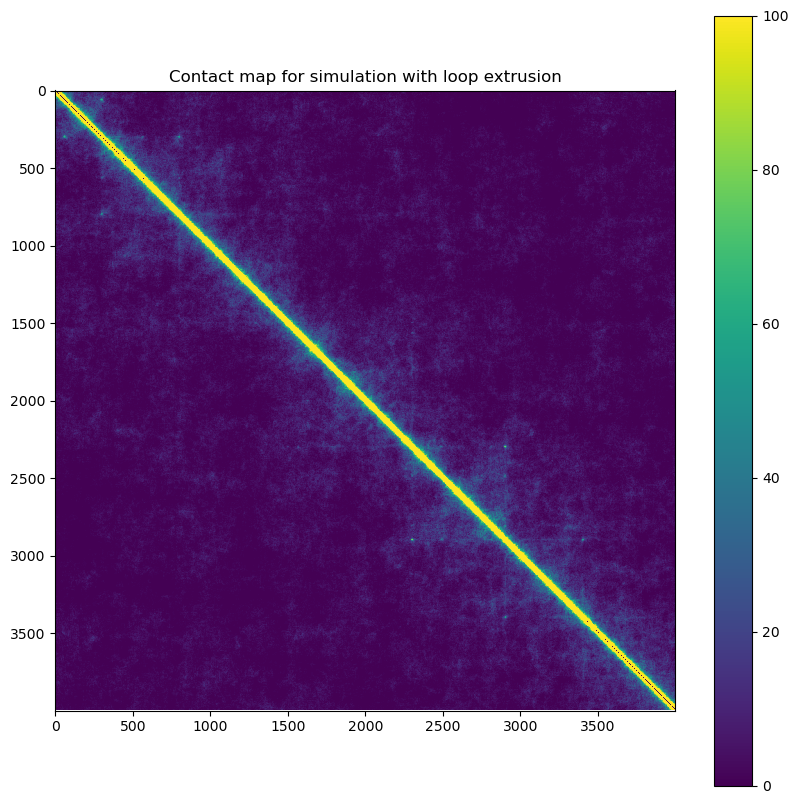

In [256]:
plt.figure(figsize=[10, 10])
plt.imshow(matrix, vmax=100, interpolation="none")
plt.colorbar()
plt.title('Contact map for simulation with loop extrusion')